In [1]:
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.

#     Written by Charalambos (Charis) Poullis - www.poullis.org

In [2]:
#Import all necessary libraries
import torch
import torchvision
import numpy as np
#progress bar functionality
import tqdm
#plotting etc
import matplotlib

import matplotlib.pyplot as plt
#random number generator
import random

# There is a weird crash in Python 3.9 causing the kernel to restart when using matplotlib
# To test if you have the same issue uncomment the following command. If it works, then you don't need the subsequent 2 lines (import os, KMP)
#plt.subplot()
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#Set the path for the datasets
DATASET_PATH = "../data"

#Download the training dataset: CIFAR10
training_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                                train=True,
                                                download=True,
                                                transform=torchvision.transforms.ToTensor())
print('Training dataset:', training_dataset)

#Download the testing dataset: CIFAR10
testing_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                               train=False,
                                               download=True,
                                               transform=torchvision.transforms.ToTensor())
print('Testing dataset:', testing_dataset)  

#Create a list with user-friendly names for each label
labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Files already downloaded and verified
Testing dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
#This function takes a CIFAR dataset and splits it into two numpy arrays containing
#the images and labels, respectively

def splitDataset(dataset):
    #Divide the datasets into images and labels
    x, y = dataset[0]
    
    shape = [(i, *j) for i, j in [(len(dataset), x.shape)]][0]
    images = np.zeros(shape)
    labels = np.zeros((len(dataset), 1))
    
    for i in range(len(dataset)):
        x,y = dataset[i]
        images[i] = x
        labels[i] = y
        
    images = np.reshape(images, (len(dataset), 3, 32, 32))
    labels = np.reshape(labels, (len(dataset), 1))
    return images, labels

In [5]:
#Divide the training datasets into images and labels; this is needed later to randomly index from the arrays
training_images, training_labels = splitDataset(training_dataset)
#Do the same for the testing dataset
testing_images, testing_labels = splitDataset(testing_dataset)   

print(f'Training images: {len(training_images)}, Training labels: {len(training_labels)}')
print(f'Testing images: {len(testing_images)}, Testing labels: {len(testing_labels)}')

Training images: 50000, Training labels: 50000
Testing images: 10000, Testing labels: 10000


In [6]:
#Define the autoencoder; This is a simple autoencoder with 2 convolutional layers in the encoder, and 2 convolutional layers in the decoder
#Put simply, an autoencoder learns to reconstruct the input
class MyAutoencoder (torch.nn.Module):
    def __init__(self):
        super(MyAutoencoder, self).__init__()
        
        #This list will keep each layer of the model
        self.layers = torch.nn.Sequential(
            #Start of encoding
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=4), #[batch_size, 32, 32, 32]
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, padding=2), #[batch_size, 8, 32, 32]
            torch.nn.ReLU(),
            #End of encoding
            #Start of decoding
            torch.nn.ConvTranspose2d(in_channels=8, out_channels=32, kernel_size=3, padding=2), #[batch_size, 8, 32, 32]
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, padding=4), #[batch_size, 32, 32, 32]
            #End of encoding
            #At this point the range of the output value is unbound. Let's use Maps the value to the range [0,1] which is expected for colors
            torch.nn.Sigmoid() 
        )
        return
    
    def forward(self, x):
        #Feed-forward the input through all the layers
        result = self.layers(x)
        return result

In [7]:
#We'll use GPU is available; check if a GPU is available
print(f'GPU devices found: {torch.cuda.device_count()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

GPU devices found: 0
Device: cpu


In [8]:
#Create an instance of the model and print; it should display all the layers and their related information
model = MyAutoencoder().to(device)
print(model)

MyAutoencoder(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (7): Sigmoid()
  )
)


In [9]:
#SANITY CHECK: Feed forward an image and check for errors
#Pull the first image from the training images, and convert to a float tensor
img = torch.from_numpy(training_images[0]).float()
print(img.shape)

#The input to the autoencoder is [batch_size, 3, 32, 32]; convert the image's shape [3,32,32] to [1,3,32,32] and push to device
img = torch.reshape(img, (1, 3, 32, 32)).to(device)

#feed forward the image to the network and make sure it works with no errors
model.forward(img)

torch.Size([3, 32, 32])


tensor([[[[0.4742, 0.4751, 0.4758,  ..., 0.4725, 0.4743, 0.4754],
          [0.4748, 0.4743, 0.4753,  ..., 0.4665, 0.4689, 0.4692],
          [0.4750, 0.4747, 0.4763,  ..., 0.4639, 0.4656, 0.4673],
          ...,
          [0.4716, 0.4656, 0.4627,  ..., 0.4609, 0.4570, 0.4618],
          [0.4695, 0.4663, 0.4638,  ..., 0.4627, 0.4604, 0.4632],
          [0.4696, 0.4679, 0.4622,  ..., 0.4664, 0.4644, 0.4652]],

         [[0.4932, 0.4960, 0.4952,  ..., 0.4953, 0.4948, 0.4948],
          [0.4923, 0.4954, 0.4960,  ..., 0.4931, 0.4925, 0.4915],
          [0.4912, 0.4945, 0.4964,  ..., 0.4894, 0.4883, 0.4881],
          ...,
          [0.4932, 0.4987, 0.4958,  ..., 0.4928, 0.4929, 0.4891],
          [0.4944, 0.4973, 0.4985,  ..., 0.4963, 0.4966, 0.4932],
          [0.4943, 0.4944, 0.4942,  ..., 0.4891, 0.4913, 0.4909]],

         [[0.5092, 0.5086, 0.5088,  ..., 0.5019, 0.5012, 0.5012],
          [0.5101, 0.5095, 0.5092,  ..., 0.5002, 0.5007, 0.4996],
          [0.5117, 0.5108, 0.5104,  ..., 0

In [10]:
#TRAINING

#define the hyperparameters
EPOCHS=20
LEARNING_RATE=0.1
BATCH_SIZE = 100

#Create an optimizer and pass the model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Define a loss function; we'll pick mean squared error since we are reconstructing the original
loss_function = torch.nn.MSELoss()

#training image indices; [0, 1, 2, 3 ....., 49999]
training_dataset_indices = torch.arange(0, len(training_dataset))

#keep track of the losses for plotting at the end
losses = list()

#Create a progress bar the size of the number of epochs
status_bar = tqdm.tqdm(range(EPOCHS), ncols=100, desc='loss: ')
for i in status_bar:
    #At each iteration, perform a permutation of the training_dataset_indices; this ensures that we will use all images and avoid duplication
    random_permutation = torch.randperm(training_dataset_indices.size()[0])

    #Get BATCH_SIZE number of training images at each epoch; because we sample from an array there will be no duplicates
    loss = None
    for b in range(0,training_dataset_indices.size()[0], BATCH_SIZE):
        #Zero out the gradients
        optimizer.zero_grad()

        #Get the indices of the training images in this batch
        batch_indices = random_permutation[b:b+BATCH_SIZE]
        #we only need to get the images; the labels are irrelevant in the context of an autoencoder
        batch_images = training_images[batch_indices]
        #convert to float tensors and push to device
        batch_images = torch.from_numpy(batch_images).float().to(device)

        #feed forward through the network's layers and get the reconstruction
        reconstructions = model.forward(batch_images)
        
        #Calculate the MSE between the reconstructions and the input images; the optimal value for this is 0
        loss = loss_function(reconstructions, batch_images)
        
        #keep track of the losses per batch, per epoch it to the list; used for plotting later on
        losses.append(loss.item())
        
        #backpropagate gradients
        loss.backward()
        #single gradient descent step; update all network parameters based on the gradient
        optimizer.step()
    
    #After every epoch update the loss function
    status_bar.set_description(f'loss: {loss.item():.8f}')

#Output the final loss on the training dataset
print(f'Final loss on training: {loss.item():.8f}')


loss:   0%|                                                                  | 0/20 [02:19<?, ?it/s]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10000,) and (282,)

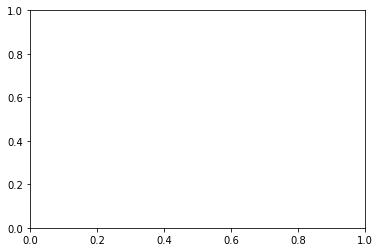

In [11]:
#Plot the loss as a function of epochs
fig, ax = plt.subplots(1,1)
ax.plot(list(range(EPOCHS*int(len(training_dataset)/BATCH_SIZE))), np.array(losses))
ax.set_title('Loss on training dataset')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')
plt.show()
fig.savefig("autoencoder_loss.png")

In [ ]:
#Calculate MSE on the testing dataset; convert to float tensors and push to device; I'm passing all the images together since it fits in the GPU
testing_images = torch.from_numpy(testing_images).float().reshape( (len(testing_images), 3, 32, 32) ).to(device)
#get the reconstructions
reconstructions = model.forward(testing_images)
testing_loss = loss_function(reconstructions, testing_images).item()
#Output the MSE loss
print(f'MSE loss on testing: {testing_loss:.8f}')

In [ ]:
#Plot a couple of examples
cols, rows = 2, 10
image_counter = 1
figure = plt.figure(figsize=(3*cols, 3*rows))
for i in range(10):
    #get a random index
    rand_index = random.randint(0, len(testing_images))
    #get the original image, pull back to cpu and convert to numpy
    original_img = testing_images[rand_index].permute(1,2,0).cpu().detach().numpy()
    #get the reconstructed image, pull back to cpu and convert to numpy
    reconstructed_img = reconstructions[rand_index].permute(1,2,0).cpu().detach().numpy()
    
    #Add a figure for the original image
    figure.add_subplot(rows, cols, image_counter)
    plt.axis("off")
    plt.imshow(original_img)
    image_counter+=1

    #Add a figure for the reconstructed image
    figure.add_subplot(rows, cols, image_counter)
    plt.axis("off")
    plt.imshow(reconstructed_img)
    image_counter+=1

plt.show()
figure.savefig("autoencoder_reconstruction.png")